In [160]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [254]:
class Value():
    def __init__(self, data, _children=(), label="", _op=""): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._op  = _op
        self.label = label
        self._prev = set(_children)
        
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op="+")
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op="*")
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), _op="tanh")
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build(child)
                topo.append(root)
        
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [242]:
from graphviz import Digraph
diam = Digraph(format="svg", graph_attr={"rankdir":"LR"})

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    diam = Digraph(format="svg", graph_attr={"rankdir":"LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        diam.node(name=uid, label="{%s | data %.4f | grad %.4f} " %(n.label, n.data, n.grad), shape="record")
        if n._op:
            diam.node(name=uid + n._op, label=n._op)
            diam.edge(uid + n._op, uid)
    
    for n1, n2 in edges: 
        diam.edge(str(id(n1)), str(id(n2)) + n2._op)
    return diam

Example with a neuron

In [259]:
# inputs valeus
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.88137, label="b")

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
L = x1w1_x2w2 + b; L.label = "L"
o = L.tanh()


In [ ]:
draw_dot(o)

In [ ]:
o.backward()

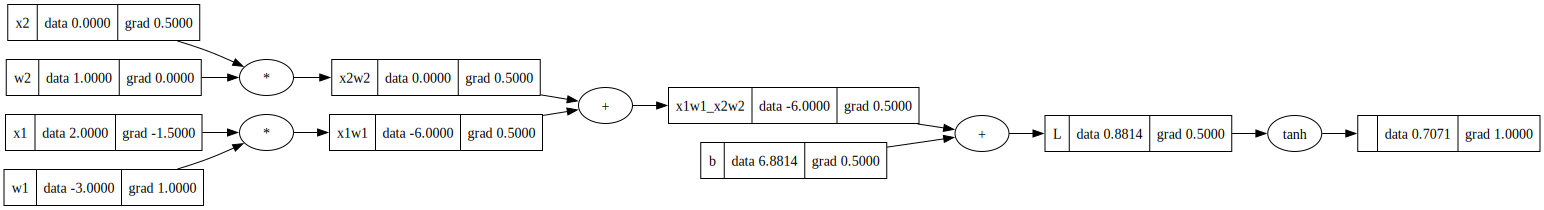

In [262]:
draw_dot(o)

Auto backpropagation for one neuron